# Connection

In [1]:
import findspark
findspark.init() 

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pyarrow.parquet as pq
import s3fs

In [3]:
spark = SparkSession.builder.appName("Dummy").master('local').config("spark.driver.memory", "60g").config('spark.dirver.maxResultSize', '6g').getOrCreate()
print("session = ", spark.getActiveSession())
config_spark_s3_adv = {'access_id': 'JLTHDJMKGTSENNZLD5YC',
                        'access_key': 'gtlSwf2xuppeomzYaAN3OFpcJiWtgAGUWNU7KIvJ',
                        'impl': 'org.apache.hadoop.fs.s3a.S3AFileSystem',
                        'endpoint': 'https://obs.ru-moscow-1.hc.sbercloud.ru',
                        'spark.driver.maxResultSize':0,
                      }

spark._jsc.hadoopConfiguration().set("fs.s3a.impl", config_spark_s3_adv["impl"])
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", config_spark_s3_adv["endpoint"])
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", config_spark_s3_adv["access_id"])
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", config_spark_s3_adv["access_key"])
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark.conf.set("spark.sql.adaptive.enabled", "false")

22/11/01 19:59:13 WARN Utils: Your hostname, ecs-test288 resolves to a loopback address: 127.0.1.1; using 10.11.10.114 instead (on interface eth0)
22/11/01 19:59:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/01 19:59:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


session =  <pyspark.sql.session.SparkSession object at 0x7f8c307c9e80>


In [4]:
spark

# Ratings target

In [5]:
path_candidates = 's3a://okko-prod/pipelines/etl-candidates_0.1/202209192359/outgoing/candidates.parquet'
full_candidates = spark.read.format('parquet').load(path_candidates)

22/11/01 19:59:42 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
full_candidates.printSchema()

root
 |-- element_uid: string (nullable = true)
 |-- user_uid: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- consumption_mode: string (nullable = true)
 |-- watched_time: integer (nullable = true)
 |-- watched_ratio: double (nullable = true)
 |-- bookmark: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [7]:
# full_candidates.show()

+--------------------+--------------------+-------------------+----------------+------------+--------------------+--------+------+
|         element_uid|            user_uid|                 ts|consumption_mode|watched_time|       watched_ratio|bookmark|rating|
+--------------------+--------------------+-------------------+----------------+------------+--------------------+--------+------+
|000d6913-68a1-413...|00000000-0019-5c8...|2021-08-12 17:12:54|               S|        2066|  0.4420196833547283|       0|     0|
|000d6913-68a1-413...|00000000-09eb-241...|2022-07-21 12:41:56|               S|        4853|  1.0382969619169875|       0|     1|
|000d6913-68a1-413...|00000000-0e9b-ba7...|2021-02-16 21:26:26|               S|        4305|  0.9210526315789473|       0|    -1|
|000d6913-68a1-413...|00000000-0ea1-844...|2021-05-10 17:03:50|               S|        4651|   0.995079161317929|       0|     0|
|000d6913-68a1-413...|00000000-0ee5-27f...|2021-09-14 10:21:06|               S|   

In [7]:
full_candidates.createOrReplaceTempView("candidates")

In [8]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import s3fs

In [10]:
s3 = s3fs.S3FileSystem(key='WA0NJOX0AFAY4K1J92XZ',
                       secret='du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT',  
                       client_kwargs={
                           'endpoint_url':'https://obs.ru-moscow-1.hc.sbercloud.ru'
                           })

In [11]:
path_candidates = "s3://okko-prod/pipelines/etl-boosting-dataset_0.1/202209091138/outgoing/boosting_dataset.par"
full_candidates = pq.ParquetDataset(path_candidates, filesystem=s3,memory_map=True).read_pandas().to_pandas()
full_candidates.head()

,user_uid,element_uid,ts,page_position,consumption_mode,watched_ratio,watched_time,bookmark,rating,tfidf_genre,tfidf_country,tfidf_actor,tfidf_director,gnn1_score,rnn1_score,date
0,00000000-0000-0000-0000-000000000000,2538f438-7ed8-4960-9b10-27109702dbbf,2022-09-09 09:59:07,2,,0.0,0,0,0,0.102839,0.230090,0.0,0.0,NaN,NaN,2022-09-09
1,00000000-0000-0000-0000-000000000000,5065fc89-d310-4482-b2a2-fe40b49d8a47,2022-09-09 17:09:46,10,,0.0,0,0,0,0.102839,0.143021,0.0,0.0,NaN,NaN,2022-09-09
2,00000000-0000-0000-0000-000000000000,aa2edb62-bebb-4ace-80dd-a1699ecd60d7,2022-09-09 18:23:38,85,,0.0,0,0,0,0.125029,0.044348,0.0,0.0,NaN,NaN,2022-09-09
3,00000000-0000-0000-0000-000000000000,c08b3c48-cf13-4117-996a-a81591d3b602,2022-09-09 09:45:16,30,,0.0,0,0,0,0.102839,0.230090,0.0,0.0,NaN,NaN,2022-09-09
4,00000000-0001-6c45-0000-000000000000,55b6d655-3e9b-4786-8f3a-471031186f6f,2022-09-09 17:43:00,35,,0.0,0,0,0,0.105438,0.847794,0.0,0.0,NaN,NaN,2022-09-09


In [13]:
full_candidates.shape

(1018363, 16)

In [12]:
full_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018363 entries, 0 to 1018362
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_uid          1018363 non-null  object 
 1   element_uid       1018363 non-null  object 
 2   ts                1018363 non-null  object 
 3   page_position     1018363 non-null  int32  
 4   consumption_mode  1018363 non-null  object 
 5   watched_ratio     1018363 non-null  float64
 6   watched_time      1018363 non-null  int32  
 7   bookmark          1018363 non-null  int32  
 8   rating            1018363 non-null  int32  
 9   tfidf_genre       1018363 non-null  float32
 10  tfidf_country     1018363 non-null  float32
 11  tfidf_actor       1018363 non-null  float32
 12  tfidf_director    1018363 non-null  float32
 13  gnn1_score        168246 non-null   float32
 14  rnn1_score        388977 non-null   float32
 15  date              1018363 non-null  object 
dtype

In [14]:
len(full_candidates['element_uid'].unique())

6692

In [15]:
len(full_candidates['user_uid'].unique())

74988

## Get min(ts) for all items

In [9]:
# start for each item
query = f"""
            SELECT
                element_uid,
                MIN(ts) as min_ts
            FROM
                candidates
            GROUP BY element_uid
            """

el_uid_min_ts = spark.sql(query)
# el_uid_min_ts.show()

In [10]:
el_uid_min_ts = el_uid_min_ts.toPandas()

In [11]:
# shape
# el_uid_min_ts.shape

In [12]:
import pickle 

with open('el_uid_min_ts.pkl', 'wb') as f:
    pickle.dump(el_uid_min_ts, f)


## Count OKKO ratings for each item 

In [13]:
# wr >= 0.5, 3 months (for movies)
voted_users_query = f"""
            SELECT 
                element_uid,
                COUNT(user_uid) as users_number
            FROM (SELECT
                     element_uid,
                     user_uid,
                     rating,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
            USING(element_uid)
            WHERE watched_ratio >= 0.5 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
            AND rating != 0
                   
            GROUP BY element_uid
          """

three_months_voted_users_wr5 = spark.sql(voted_users_query)
# three_months_voted_users_wr5.show()

In [14]:
three_months_voted_users_wr5 = three_months_voted_users_wr5.toPandas()

In [15]:
three_months_voted_users_wr5.shape

(9323, 2)

In [16]:
three_months_voted_users_wr5

,element_uid,users_number
0,03b5e971-19db-4cfe-9421-758965e44fe4,25
1,07b3c184-a44c-4ada-84fb-4a3804294efb,5
2,0a75caf0-9bdc-4a67-b291-31377ec95b81,33
3,0e73e987-c4cb-459c-a0f7-abd0df44685d,2
4,13244750-51d7-4b67-801a-4229077642fa,29
...,...,...
9318,db301c37-1d1c-4532-94ba-27148ee68339,1
9319,e2c89ec3-a004-4c3e-9657-897db7e03eeb,1
9320,e3a4a622-a338-48f1-bada-026fc8c34b3a,45
9321,eabd5002-7460-453f-bd1d-e517a3ef4044,453


In [17]:
# wr >= 0.5, 3 months (for movies)
query = f"""
            SELECT 
                element_uid,
                SUM(rating)/COUNT(rating) as av_rate
            FROM (SELECT
                     element_uid,
                     rating,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
            USING(element_uid)
            WHERE watched_ratio >= 0.5 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
                   
            GROUP BY element_uid
          """

three_months_ratings = spark.sql(query)
# three_months_ratings.show()

In [18]:
three_months_ratings = three_months_ratings.toPandas()

In [19]:
three_months_ratings

,element_uid,av_rate
0,03b5e971-19db-4cfe-9421-758965e44fe4,0.005697
1,062898a3-7cfa-4f2b-9449-62ab856947fe,0.000000
2,07b3c184-a44c-4ada-84fb-4a3804294efb,0.009740
3,0a75caf0-9bdc-4a67-b291-31377ec95b81,0.030464
4,0e145f6c-b6c7-4483-9ad2-9cbda3c6f010,0.000000
...,...,...
12126,db301c37-1d1c-4532-94ba-27148ee68339,0.043478
12127,e2c89ec3-a004-4c3e-9657-897db7e03eeb,0.142857
12128,e3a4a622-a338-48f1-bada-026fc8c34b3a,0.014522
12129,eabd5002-7460-453f-bd1d-e517a3ef4044,0.023093


In [20]:
three_months_ratings.shape

(12131, 2)

In [21]:
# wr >= 0.3, 3 months (for serials)
voted_users_query = f"""
            SELECT 
                element_uid,
                COUNT(user_uid) as users_number
            FROM (SELECT
                     element_uid,
                     user_uid,
                     rating,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
            USING(element_uid)
            WHERE watched_ratio >= 0.3 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
            AND rating != 0
                   
            GROUP BY element_uid
          """

three_months_voted_users_wr3 = spark.sql(voted_users_query)
# three_months_voted_users_wr3.show()

In [22]:
three_months_voted_users_wr3 = three_months_voted_users_wr3.toPandas()

In [23]:
three_months_voted_users_wr3.shape

(9391, 2)

In [24]:
three_months_voted_users_wr3

,element_uid,users_number
0,03b5e971-19db-4cfe-9421-758965e44fe4,27
1,07b3c184-a44c-4ada-84fb-4a3804294efb,5
2,0a75caf0-9bdc-4a67-b291-31377ec95b81,34
3,0e73e987-c4cb-459c-a0f7-abd0df44685d,2
4,13244750-51d7-4b67-801a-4229077642fa,31
...,...,...
9386,db301c37-1d1c-4532-94ba-27148ee68339,1
9387,e2c89ec3-a004-4c3e-9657-897db7e03eeb,1
9388,e3a4a622-a338-48f1-bada-026fc8c34b3a,45
9389,eabd5002-7460-453f-bd1d-e517a3ef4044,461


In [25]:
# wr >= 0.3, 3 months (for serials)
query = f"""
            SELECT 
                element_uid,
                SUM(rating)/ COUNT(rating) as av_rate
            FROM (SELECT
                     element_uid,
                     rating,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
            USING(element_uid)
            WHERE watched_ratio >= 0.3 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
            GROUP BY element_uid
          """

three_months_ratings_wr30 = spark.sql(query)
# three_months_ratings_wr30.show()

In [26]:
three_months_ratings_wr30 = three_months_ratings_wr30.toPandas()

In [27]:
three_months_ratings_wr30

,element_uid,av_rate
0,03b5e971-19db-4cfe-9421-758965e44fe4,0.006063
1,062898a3-7cfa-4f2b-9449-62ab856947fe,0.000000
2,07b3c184-a44c-4ada-84fb-4a3804294efb,0.008798
3,0a75caf0-9bdc-4a67-b291-31377ec95b81,0.026253
4,0e145f6c-b6c7-4483-9ad2-9cbda3c6f010,0.000000
...,...,...
12176,db301c37-1d1c-4532-94ba-27148ee68339,0.040000
12177,e2c89ec3-a004-4c3e-9657-897db7e03eeb,0.111111
12178,e3a4a622-a338-48f1-bada-026fc8c34b3a,0.011988
12179,eabd5002-7460-453f-bd1d-e517a3ef4044,0.020122


In [28]:
three_months_ratings_wr30.shape

(12181, 2)

## Merging datasets

In [29]:
# content features from ./content_features_creation
with open('elements_available.pkl', 'rb') as f:
    elements_available = pickle.load(f)

In [30]:
elements_available

,availability,children,subscription_only,average_rating,age_access_type,uid,release_type,age_restriction_aliases,box_office_russia,country,...,genre,type,release_year,budget,duration,name,alias,box_office_worldwide,sale_start_date,actor
e785baa6-f175-42b4-9e16-4319ac7991d5,"[DTO, RENT, SUBSCRIPTION]",NaN,False,6.21,12,e785baa6-f175-42b4-9e16-4319ac7991d5,RELEASE,[CR_9_13],NaN,[usa],...,"[Sci-Fi, Action, Thriller, Adventure]",MOVIE,1989,27800000,6420000,Звёздный путь 5: Последний рубеж,star-trek-v-the-final-frontier,NaN,1277323200000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45..."
4593737e-de9c-40df-97db-fb3cf85a08ef,"[DTO, RENT, SUBSCRIPTION]",NaN,False,7.2,16,4593737e-de9c-40df-97db-fb3cf85a08ef,RELEASE,NaN,NaN,[usa],...,"[Sci-Fi, Action, Thriller, Adventure]",MOVIE,1991,30000000,6780000,Звёздный путь 6: Неоткрытая страна,star-trek-vi-the-undiscovered-country,NaN,1277323200000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45..."
11ba66db-e941-4c3a-8da6-d8900e56f8c7,"[DTO, RENT, SUBSCRIPTION]",NaN,False,4.0,18,11ba66db-e941-4c3a-8da6-d8900e56f8c7,RELEASE,NaN,NaN,[usa],...,[Horror],MOVIE,2019,NaN,6000000,В поисках древнего артефакта,devils-revenge,NaN,1638479280894,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, bcad17e..."
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,[SUBSCRIPTION],NaN,True,6.99,18,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,RELEASE,NaN,NaN,[usa],...,"[Comedy, Documentary]",MOVIE,2011,NaN,3780000,Прожарка Чарли Шина,the-roast-of-charlie-sheen,NaN,1605042957019,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 30dd19c..."
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,[SUBSCRIPTION],NaN,True,6.0,18,cdfa700f-122d-41e5-b8dc-9c6813bab6d2,RELEASE,NaN,NaN,[usa],...,[Comedy],MOVIE,2006,NaN,3780000,Прожарка Уильяма Шэтнера,the-roast-of-william-shatner,NaN,1608153790877,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a805fdd..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac0c9152-c070-43a0-bb99-7e72764b7c0a,[SUBSCRIPTION],[1f9803c3-4a07-48cd-92b5-3917454a7fc3],True,NaN,0,ac0c9152-c070-43a0-bb99-7e72764b7c0a,RELEASE,"[CR_0_4, CR_5_8]",NaN,[brasil],...,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],SERIAL,2019,NaN,5400000,Изобретая игры,inventing-games,NaN,1661980015141,[d08bba89-e937-40f3-b2a7-7ea26de4c246]
ce8d2906-a33f-4140-9ffe-e091990d71a4,"[SUBSCRIPTION, AVOD]",[6cff0a01-04a1-434a-9b26-a53811ec6055],False,NaN,6,ce8d2906-a33f-4140-9ffe-e091990d71a4,RELEASE,"[CR_5_8, CR_9_13]",NaN,[russia],...,"[ForKids, 1f22ccf1-288a-4e6e-b39a-7502799e7125]",SERIAL,2022,NaN,3600000,Большие игры,bolshie-igry,NaN,1661807225707,[50ed4519-ad24-47b3-b135-947dba796372]
0bfb5a13-50fc-48f3-b51a-a30971024651,[SUBSCRIPTION],[4b5dbaea-2251-4d10-b961-e99568373933],True,NaN,0,0bfb5a13-50fc-48f3-b51a-a30971024651,RELEASE,"[CR_0_4, CR_0_13, CR_5_8, CR_9_13]",NaN,[china],...,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],SERIAL,2021,NaN,40560000,Природный патруль,environmental-task-force,NaN,1661980015141,"[d658fbcd-8e80-4880-a25c-e7a209998969, b6fe1a3..."
6dd86e60-5d6d-475d-9b46-e989ac7a30b6,[SUBSCRIPTION],[2a824654-3e0a-430d-ad0c-daf829e725c9],True,NaN,6,6dd86e60-5d6d-475d-9b46-e989ac7a30b6,RELEASE,"[CR_5_8, CR_9_13]",NaN,[china],...,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],SERIAL,2022,NaN,40560000,Истоки футбола,cuju-squad,NaN,1661980015141,"[7f914cdf-be41-401d-a828-4766ad70abd6, ca04375..."


In [31]:
el_uid_min_ts['min_ts'] = el_uid_min_ts['min_ts'].astype('datetime64[ns]')

In [32]:
import datetime

el_uid_min_ts[el_uid_min_ts['min_ts'] < datetime.datetime.strptime(f'2020.10', "%Y.%m")]

,element_uid,min_ts
0,03b5e971-19db-4cfe-9421-758965e44fe4,2020-09-20 00:04:17
2,07b3c184-a44c-4ada-84fb-4a3804294efb,2020-09-20 08:13:41
4,0e145f6c-b6c7-4483-9ad2-9cbda3c6f010,2020-09-22 12:29:19
6,13244750-51d7-4b67-801a-4229077642fa,2020-09-20 00:46:12
8,1459fe0a-bd84-4bea-a8c7-c00933262cd0,2020-09-20 00:22:03
...,...,...
12739,d1abb870-be4e-4004-b844-f9604e7cf673,2020-09-20 05:44:10
12740,d43fad39-794c-4f21-8da0-60a5fcda732b,2020-09-21 01:29:07
12741,daf1ca56-2868-481e-8003-fec7d812db58,2020-09-20 00:26:30
12742,db301c37-1d1c-4532-94ba-27148ee68339,2020-09-20 07:27:22


In [33]:
# merge content features, views for 3 months wr 0.5 & views for 3 months wr 0.3
el_uid_views = elements_available.merge(three_months_ratings,
                                       left_on='uid',
                                       right_on='element_uid',
                                           how='inner').merge(three_months_ratings_wr30,
                                                               on='element_uid',
                                                               how='inner').merge(three_months_voted_users_wr5,
                                                               on='element_uid',
                                                               how='inner').merge(three_months_voted_users_wr3,
                                                               on='element_uid',
                                                               how='inner')

In [34]:
el_uid_views.head().T

,0,1,2,3,4
availability,[SUBSCRIPTION],[SUBSCRIPTION],[SUBSCRIPTION],[SUBSCRIPTION],"[DTO, RENT]"
children,NaN,NaN,NaN,NaN,NaN
subscription_only,True,True,True,True,False
average_rating,6.99,6.0,6.21,6.4,NaN
age_access_type,18,18,0,6,16
uid,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,cdfa700f-122d-41e5-b8dc-9c6813bab6d2,d8b55146-dee5-4498-957c-5614414b48fb,ba6bec1a-3aa9-48c7-aa65-908c21627a12,a367ca50-ef7d-4a4c-b89a-c8692defa697
release_type,RELEASE,RELEASE,RELEASE,RELEASE,RELEASE
age_restriction_aliases,NaN,NaN,"[CR_0_4, CR_5_8]","[CR_5_8, CR_9_13]",NaN
box_office_russia,NaN,NaN,NaN,1236383,NaN
country,[usa],[usa],"[usa, canada]","[canada, france]",[usa]


In [35]:
el_uid_views.shape

(9323, 27)

In [36]:
# select relevant features
feature_columns = ['availability', 'actor', 'age_access_type', 'country',
                   'average_rating', 'duration', 'type',
                   'name', 'release_year','genre', 
                   'director', 'element_uid', 'subscription_only', 
                   'av_rate_x', 'av_rate_y',
                   'users_number_x', 'users_number_y']

dataset = el_uid_views[feature_columns]

In [37]:
dataset.shape

(9323, 17)

In [38]:
dataset.isnull().sum()

availability          92
actor                  0
age_access_type        0
country                0
average_rating       474
duration               0
type                   0
name                   0
release_year           0
genre                  0
director               0
element_uid            0
subscription_only      0
av_rate_x              0
av_rate_y              0
users_number_x         0
users_number_y         0
dtype: int64

In [39]:
# finally define number of users for series and movies
dataset['user_count_3months'] = [dataset.loc[i, 'users_number_x'] if 'MOVIE' in t else dataset.loc[i, 'users_number_y'] 
                                                                     for i, t in zip(dataset.index, dataset['type'])]

/tmp/ipykernel_1953906/3495437644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['user_count_3months'] = [dataset.loc[i, 'users_number_x'] if 'MOVIE' in t else dataset.loc[i, 'users_number_y']


In [40]:
# finally define number of users for series and movies
dataset['av_ratings_3months'] = [dataset.loc[i, 'av_rate_x'] if 'MOVIE' in t else dataset.loc[i, 'av_rate_y'] 
                                                                     for i, t in zip(dataset.index, dataset['type'])]

/tmp/ipykernel_1953906/1506101619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['av_ratings_3months'] = [dataset.loc[i, 'av_rate_x'] if 'MOVIE' in t else dataset.loc[i, 'av_rate_y']


In [41]:
el_uid_min_ts.shape

(12748, 2)

In [42]:
# add timestamps 
dataset = dataset.merge(el_uid_min_ts,
                        on='element_uid')

In [43]:
dataset.shape

(9323, 20)

In [44]:
dataset.head().T

,0,1,2,3,4
availability,[SUBSCRIPTION],[SUBSCRIPTION],[SUBSCRIPTION],[SUBSCRIPTION],"[DTO, RENT]"
actor,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 30dd19c...","[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a805fdd...","[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a51b376...","[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 873fd46...","[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 39124be..."
age_access_type,18,18,0,6,16
country,[usa],[usa],"[usa, canada]","[canada, france]",[usa]
average_rating,6.99,6.0,6.21,6.4,NaN
duration,3780000,3780000,4860000,5520000,5280000
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
name,Прожарка Чарли Шина,Прожарка Уильяма Шэтнера,Большое путешествие,Пламенное сердце,Роман с кукушкой
release_year,2011,2006,2006,2022,2021
genre,"[Comedy, Documentary]",[Comedy],"[Family, 287a1485-7a88-4c2f-bc94-ca418b6c47a1]","[Comedy, Adventure, Family, 287a1485-7a88-4c2f...","[Comedy, Melodrama, Drama]"


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


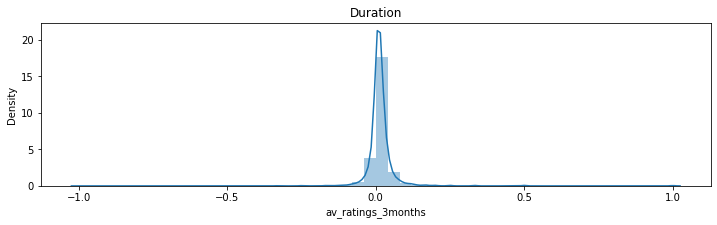

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


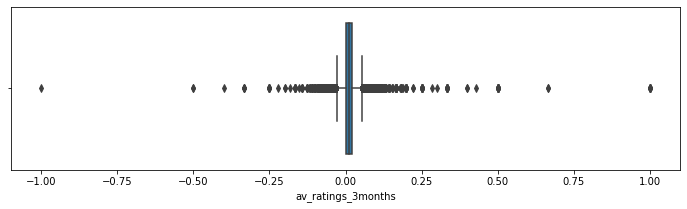

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3)) 
sns.distplot(dataset['av_ratings_3months'])
plt.title('Duration')
plt.show()

plt.figure(figsize=(12, 3))
sns.boxplot(dataset['av_ratings_3months'], orient='h')
plt.show()

In [46]:
import pickle

with open('RATINGS_OKKO_item_coldstart_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)